In [1]:
import math

import import_ipynb
from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from aqi_epa_pm25.ipynb
PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_2BBA    float64
TANGARA_260A    float64
TANGARA_4B1A    float64
TANGARA_14D6    float64
TANGARA_1EE6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_307A    float64
TANGARA_1712    float64
TANGARA_48C6    float64
TANGARA_532E    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
dtype: object


,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,,,,
2023-10-05 22:58:30-05:00,11.0,8.0,7.0,NaN,NaN,6.0,7.0,NaN,11.0,13.0,2.0,2.0,6.0,0.0
2023-10-05 22:59:00-05:00,10.0,7.0,7.0,NaN,NaN,6.0,5.0,NaN,10.0,13.0,2.0,3.0,6.0,0.0
2023-10-05 22:59:30-05:00,10.0,7.0,7.0,NaN,NaN,5.0,5.0,NaN,11.0,14.0,3.0,4.0,6.0,0.0
2023-10-05 23:00:00-05:00,10.0,7.0,7.0,NaN,NaN,5.0,4.0,NaN,11.0,13.0,3.0,4.0,7.0,0.0
2023-10-05 23:00:30-05:00,10.0,7.0,6.0,NaN,NaN,5.0,7.0,NaN,11.0,13.0,2.0,2.0,7.0,0.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,2708.000000,2619.000000,2666.000000,1303.000000,2552.000000,2333.000000,2579.000000,2535.000000,2647.000000,2666.000000,2602.00000,2697.000000,2693.000000,2682.000000
mean,8.597858,10.864834,20.539385,13.214121,11.654781,11.763823,9.324932,11.542801,12.012845,13.578395,8.39239,9.943270,10.751207,0.001491
std,3.521273,5.413115,78.506616,9.977442,11.534396,4.506564,4.982347,4.781125,3.958284,7.736178,4.91920,19.195661,6.773158,0.038597
min,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,5.000000,4.000000,5.000000,0.00000,0.000000,3.000000,0.000000
25%,6.000000,6.000000,5.000000,9.000000,5.000000,8.000000,5.000000,8.000000,9.000000,9.000000,5.00000,5.000000,7.000000,0.000000
50%,8.000000,10.000000,10.000000,11.000000,7.000000,11.000000,8.000000,10.000000,12.000000,12.000000,7.00000,7.000000,9.000000,0.000000
75%,11.000000,13.000000,23.000000,13.000000,14.000000,16.000000,13.000000,13.000000,15.000000,16.000000,11.00000,12.000000,13.000000,0.000000
max,35.000000,37.000000,2061.000000,78.000000,257.000000,23.000000,32.000000,29.000000,26.000000,77.000000,76.00000,604.000000,66.000000,1.000000


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%
Tangara Sensor: TANGARA_14D6, Data: 45%, Missing: 55%, To be checked
Tangara Sensor: TANGARA_1EE6, Data: 89%, Missing: 11%, To be checked
Tangara Sensor: TANGARA_2B42, Data: 81%, Missing: 19%, To be checked
Tangara Sensor: TANGARA_2FF6, Data: 88%, Missing: 12%, To be checked


## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
if not math.isnan(df_reference_sensor.std()):
    is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
    if not is_ok:
        print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

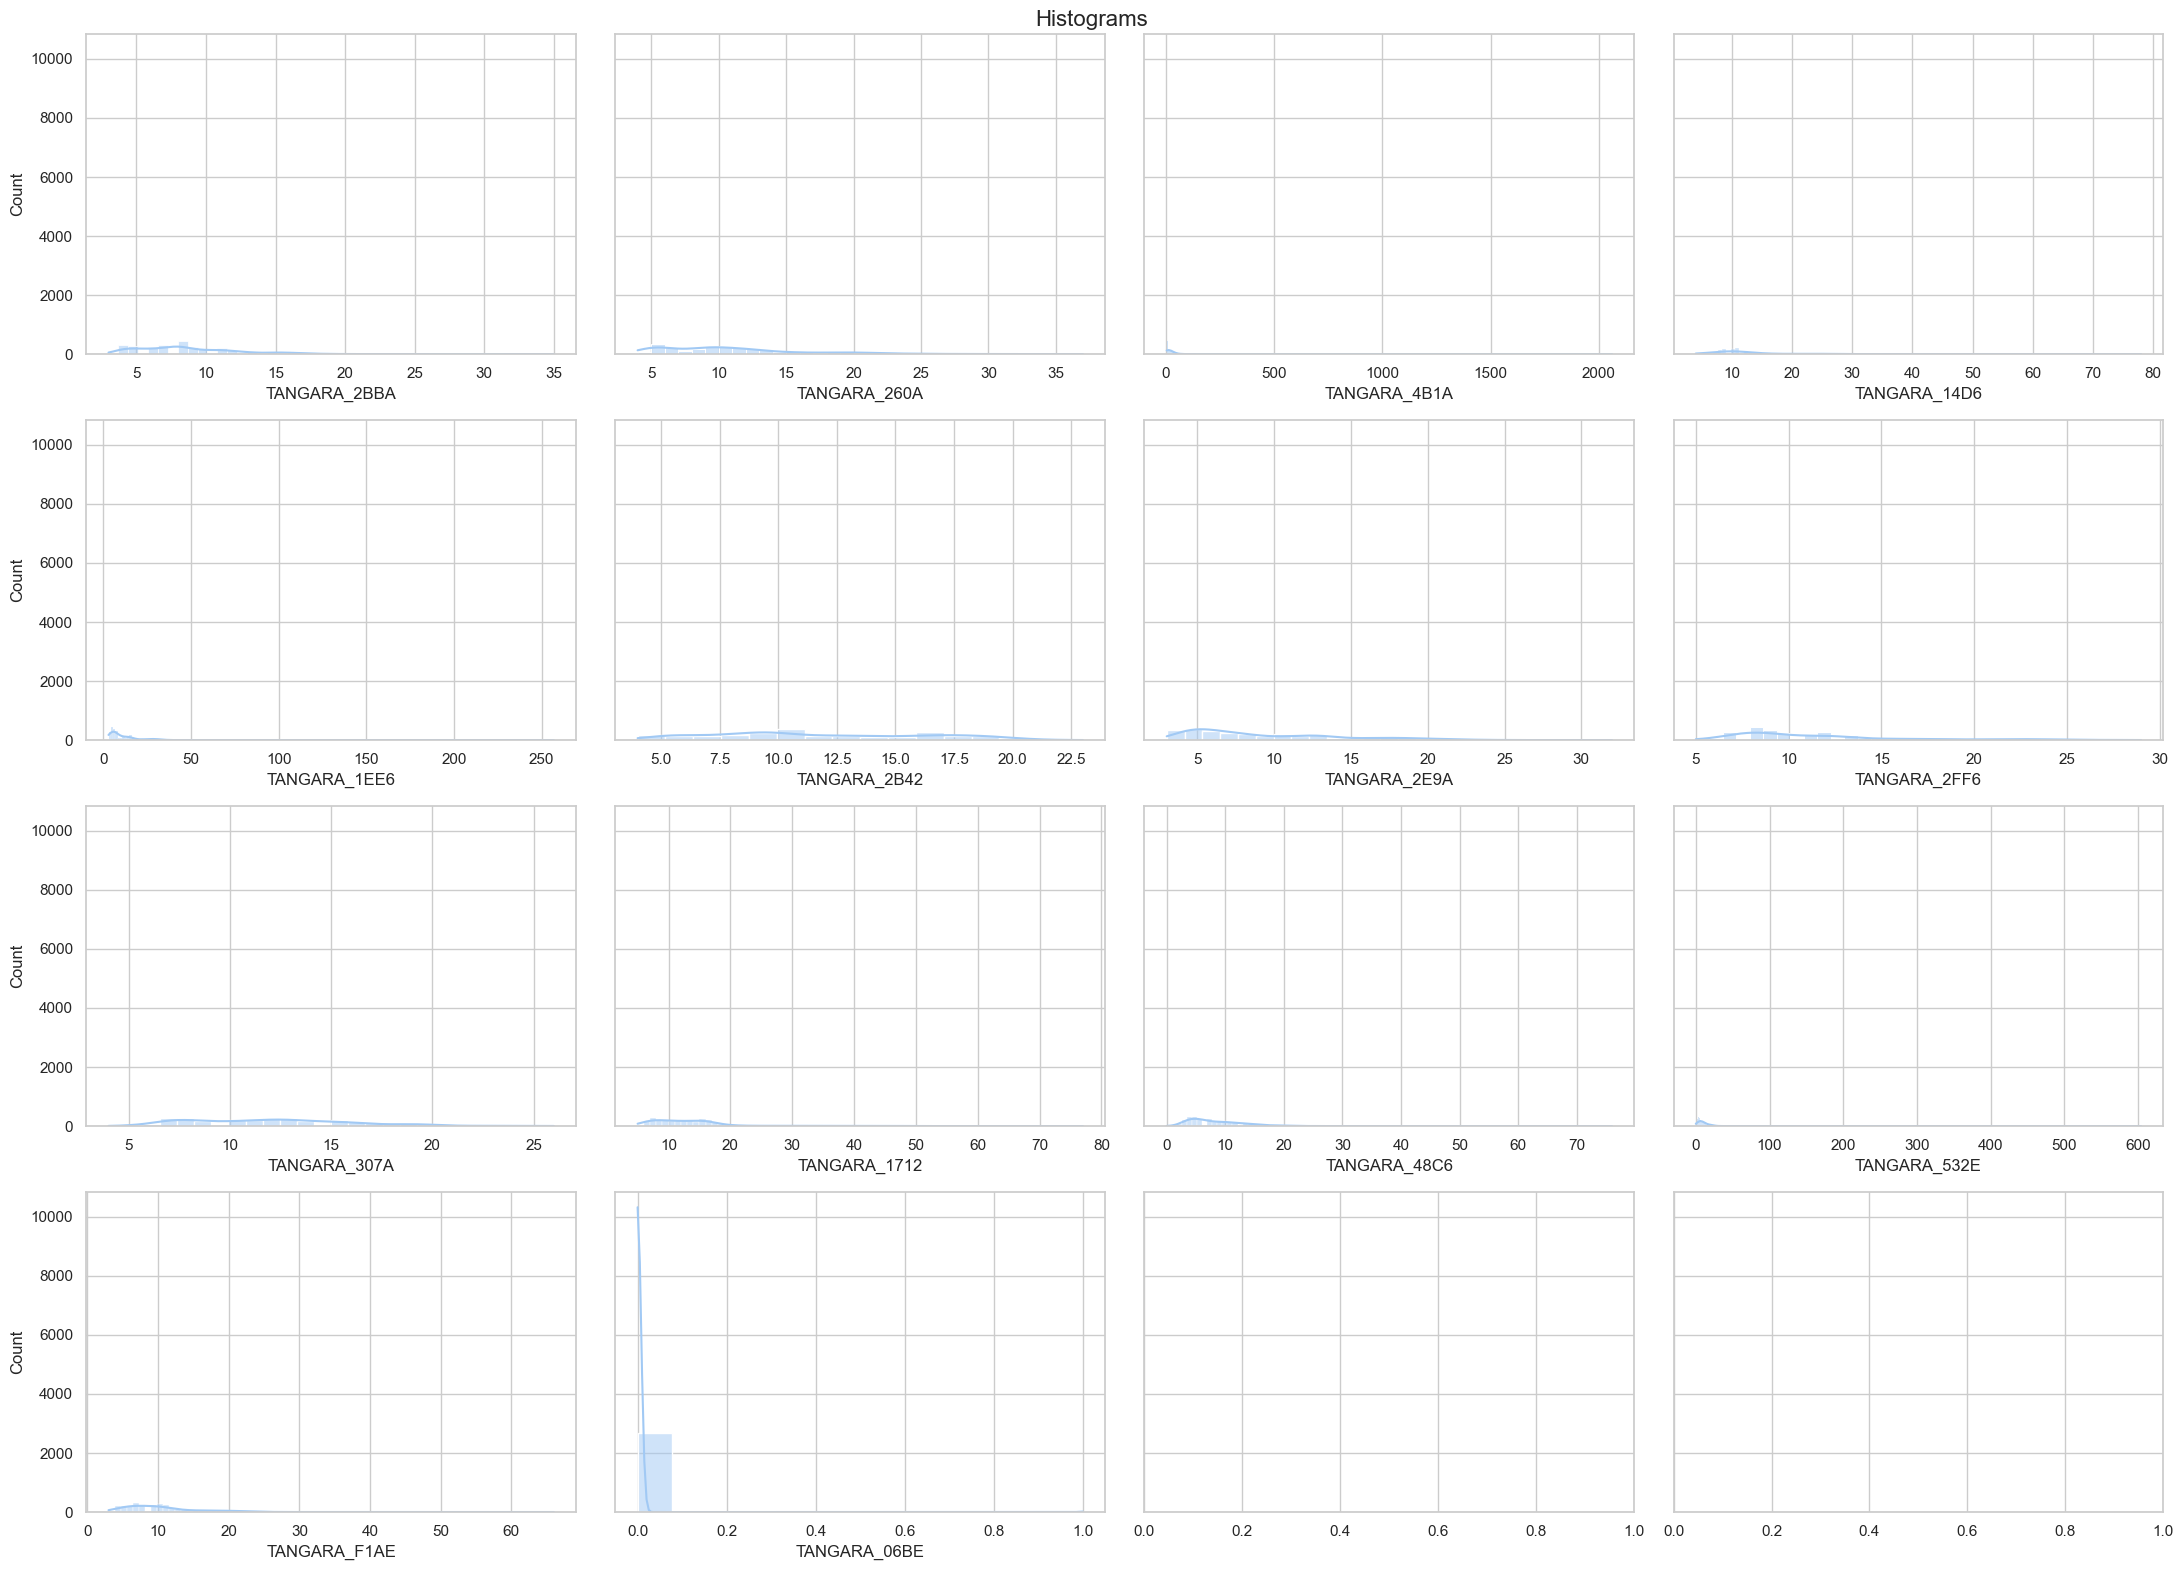

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

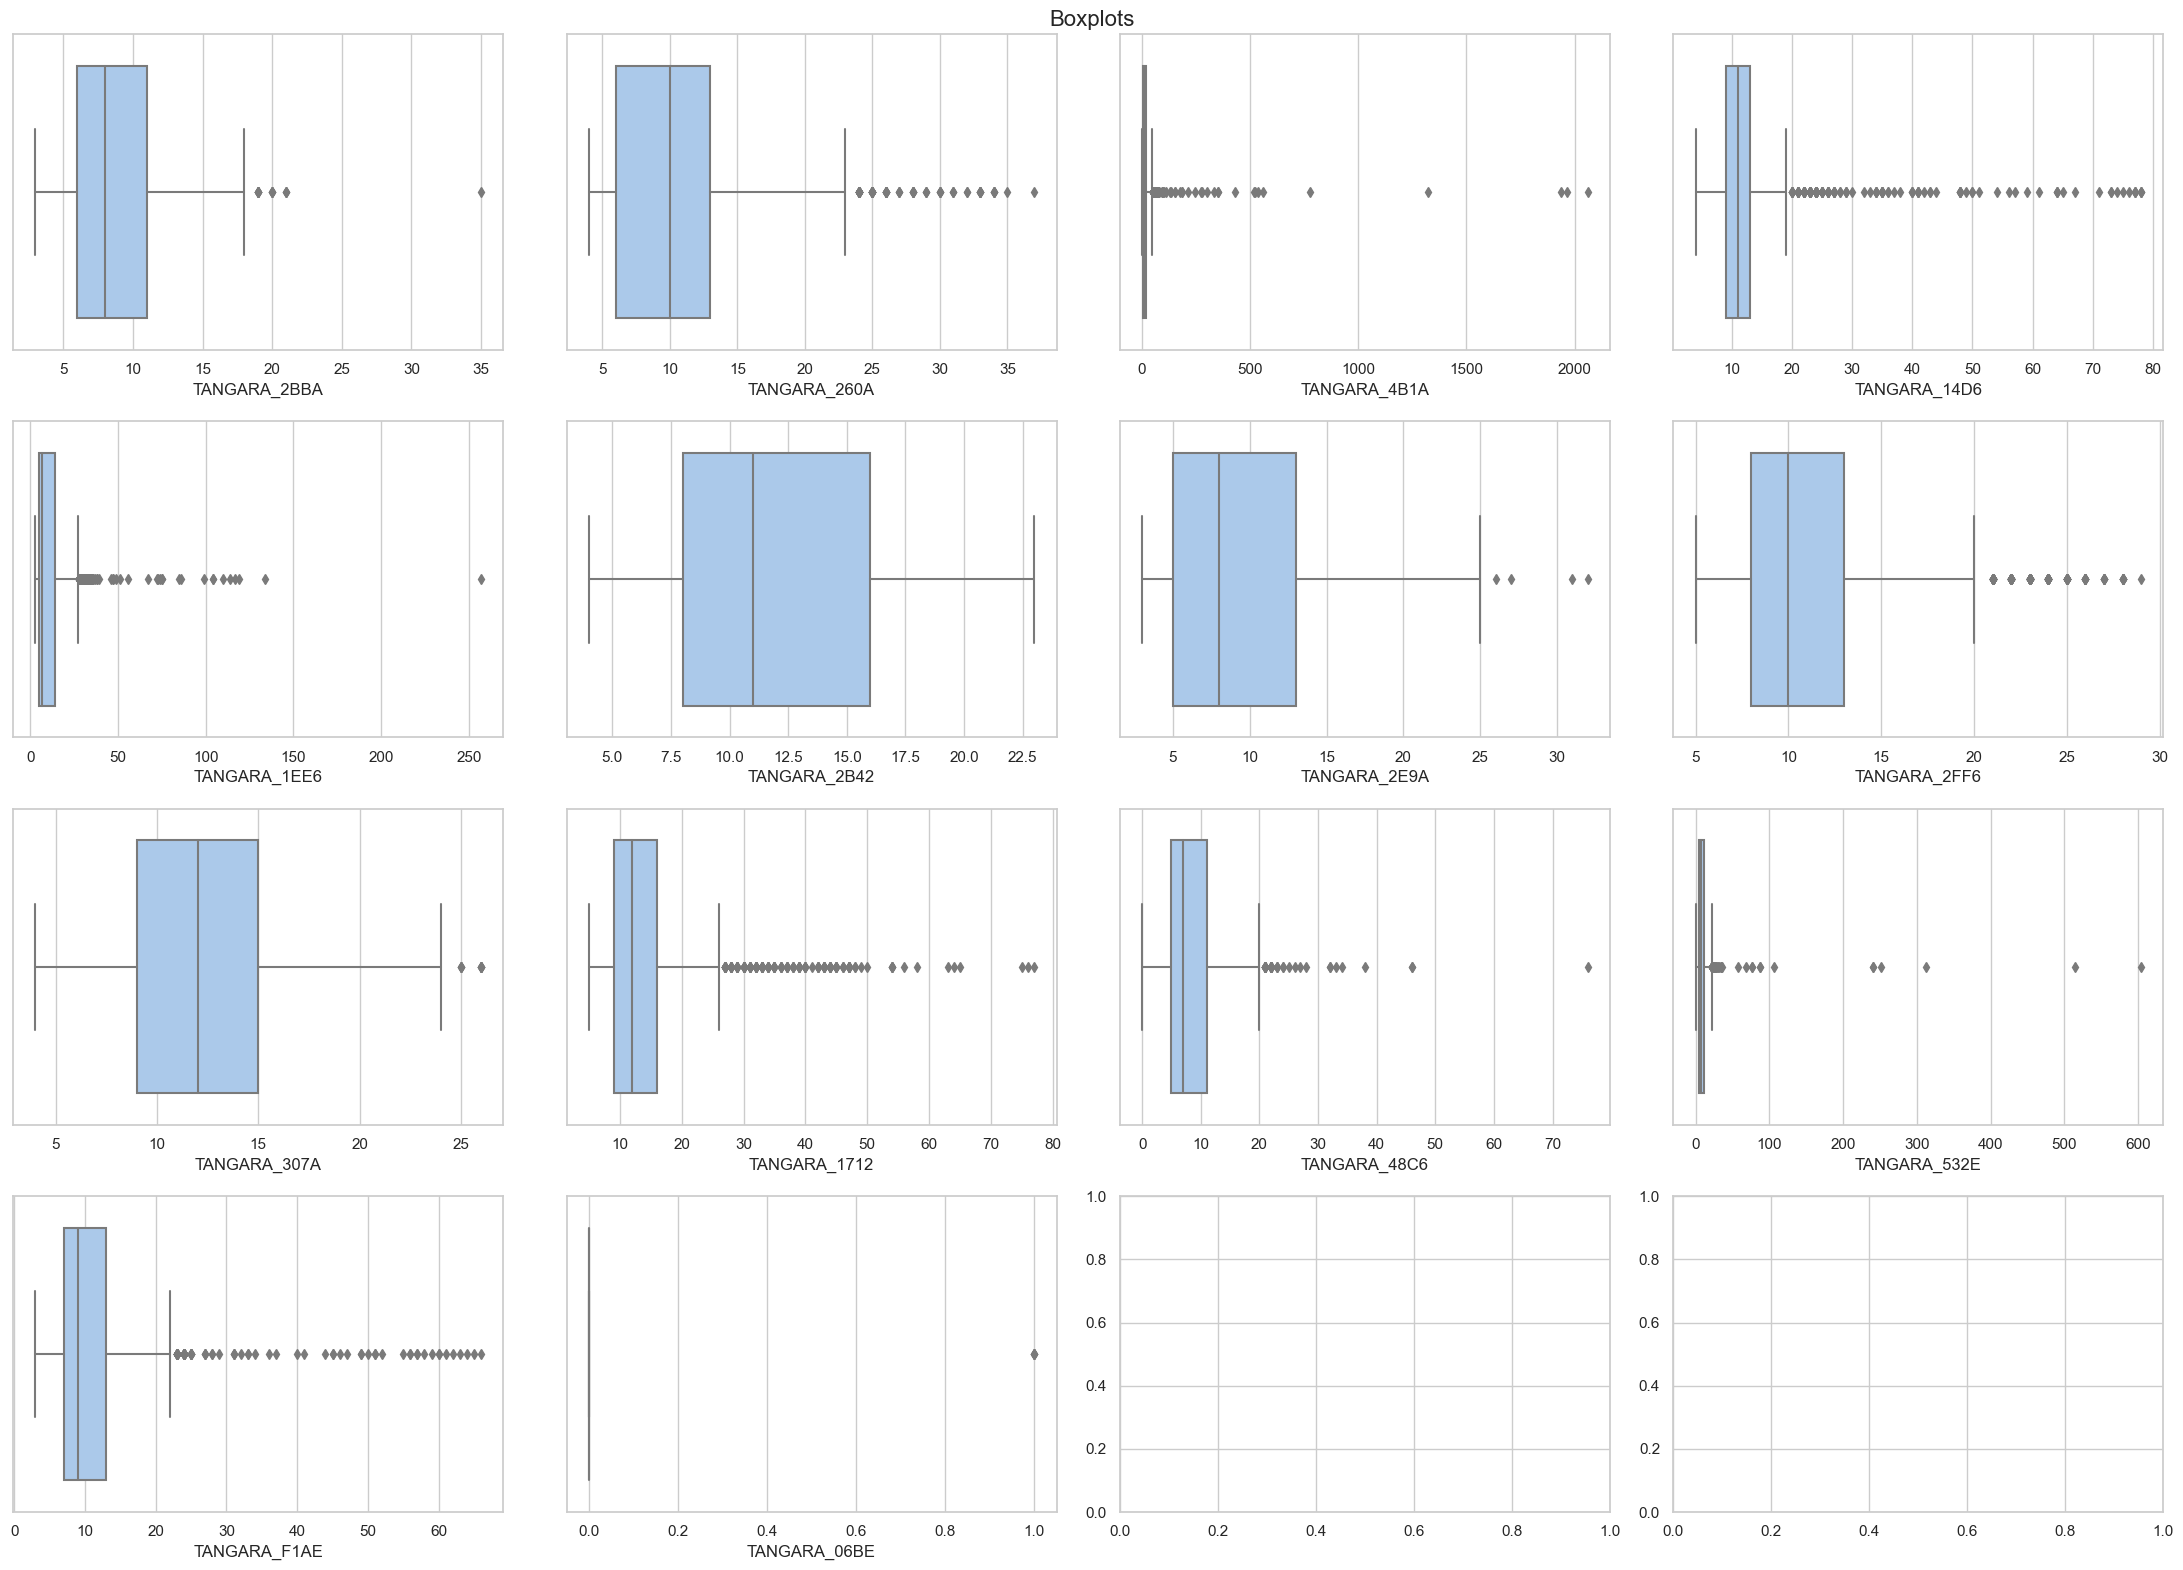

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

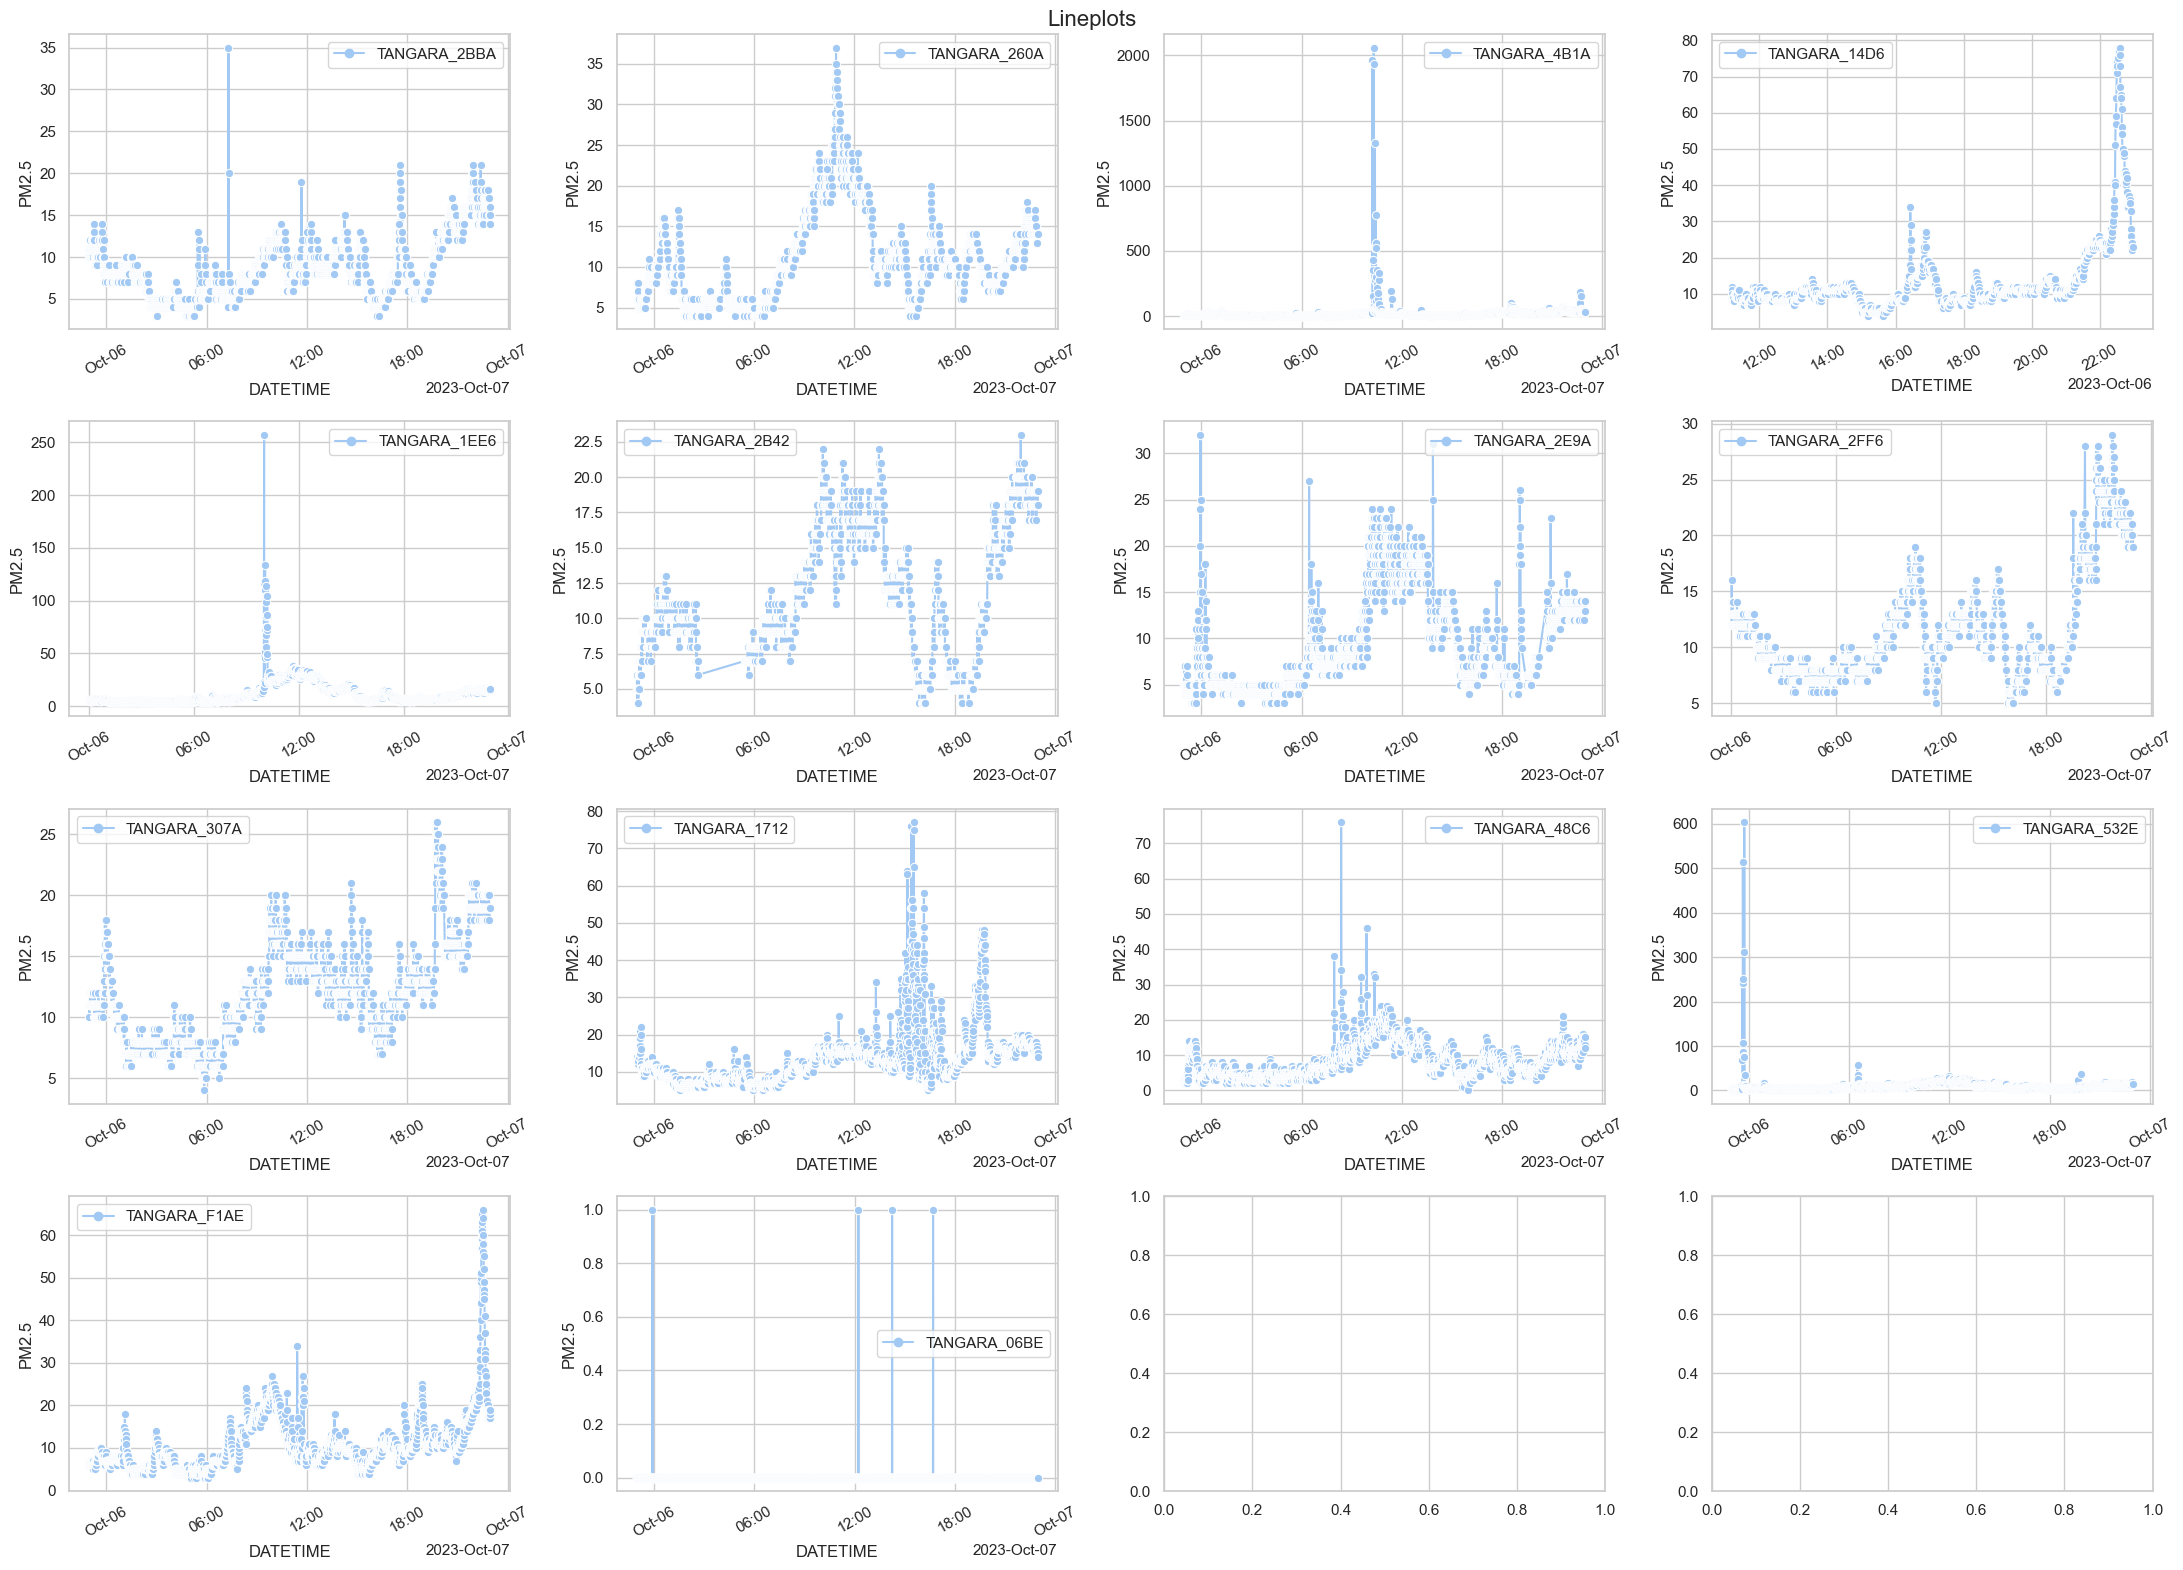

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,2693.000000,2545.000000,2567.000000,1128.000000,2343.000000,2333.000000,2575.000000,2320.000000,2637.000000,2505.000000,2559.000000,2604.000000,2597.000000,2678.0
mean,8.530264,10.381139,14.042462,10.179965,9.373453,11.763823,9.294369,10.454741,11.961320,12.025948,8.095741,8.486175,9.904890,0.0
std,3.399851,4.637076,10.927316,2.736987,5.612989,4.506564,4.924404,3.269895,3.876021,4.195660,4.199834,5.186217,4.510026,0.0
min,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,5.000000,4.000000,5.000000,0.000000,0.000000,3.000000,0.0
25%,6.000000,6.000000,5.000000,8.000000,5.000000,8.000000,5.000000,8.000000,9.000000,8.000000,5.000000,4.000000,7.000000,0.0
50%,8.000000,10.000000,9.000000,10.000000,7.000000,11.000000,8.000000,10.000000,12.000000,12.000000,7.000000,7.000000,9.000000,0.0
75%,11.000000,13.000000,22.000000,11.000000,13.000000,16.000000,13.000000,12.000000,15.000000,15.000000,11.000000,11.000000,12.000000,0.0
max,18.000000,23.000000,50.000000,19.000000,27.000000,23.000000,25.000000,20.000000,24.000000,26.000000,20.000000,22.000000,22.000000,0.0


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,2693.000000,2545.000000,2567.000000,1128.000000,2343.000000,2333.000000,2575.000000,2320.000000,2637.000000,2505.000000,2559.000000,2604.000000,2597.000000,2678.0
mean,8.530264,10.381139,14.042462,10.179965,9.373453,11.763823,9.294369,10.454741,11.961320,12.025948,8.095741,8.486175,9.904890,0.0
std,3.399851,4.637076,10.927316,2.736987,5.612989,4.506564,4.924404,3.269895,3.876021,4.195660,4.199834,5.186217,4.510026,0.0
min,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,5.000000,4.000000,5.000000,0.000000,0.000000,3.000000,0.0
25%,6.000000,6.000000,5.000000,8.000000,5.000000,8.000000,5.000000,8.000000,9.000000,8.000000,5.000000,4.000000,7.000000,0.0
50%,8.000000,10.000000,9.000000,10.000000,7.000000,11.000000,8.000000,10.000000,12.000000,12.000000,7.000000,7.000000,9.000000,0.0
75%,11.000000,13.000000,22.000000,11.000000,13.000000,16.000000,13.000000,12.000000,15.000000,15.000000,11.000000,11.000000,12.000000,0.0
max,18.000000,23.000000,50.000000,19.000000,27.000000,23.000000,25.000000,20.000000,24.000000,26.000000,20.000000,22.000000,22.000000,0.0


## Histograms

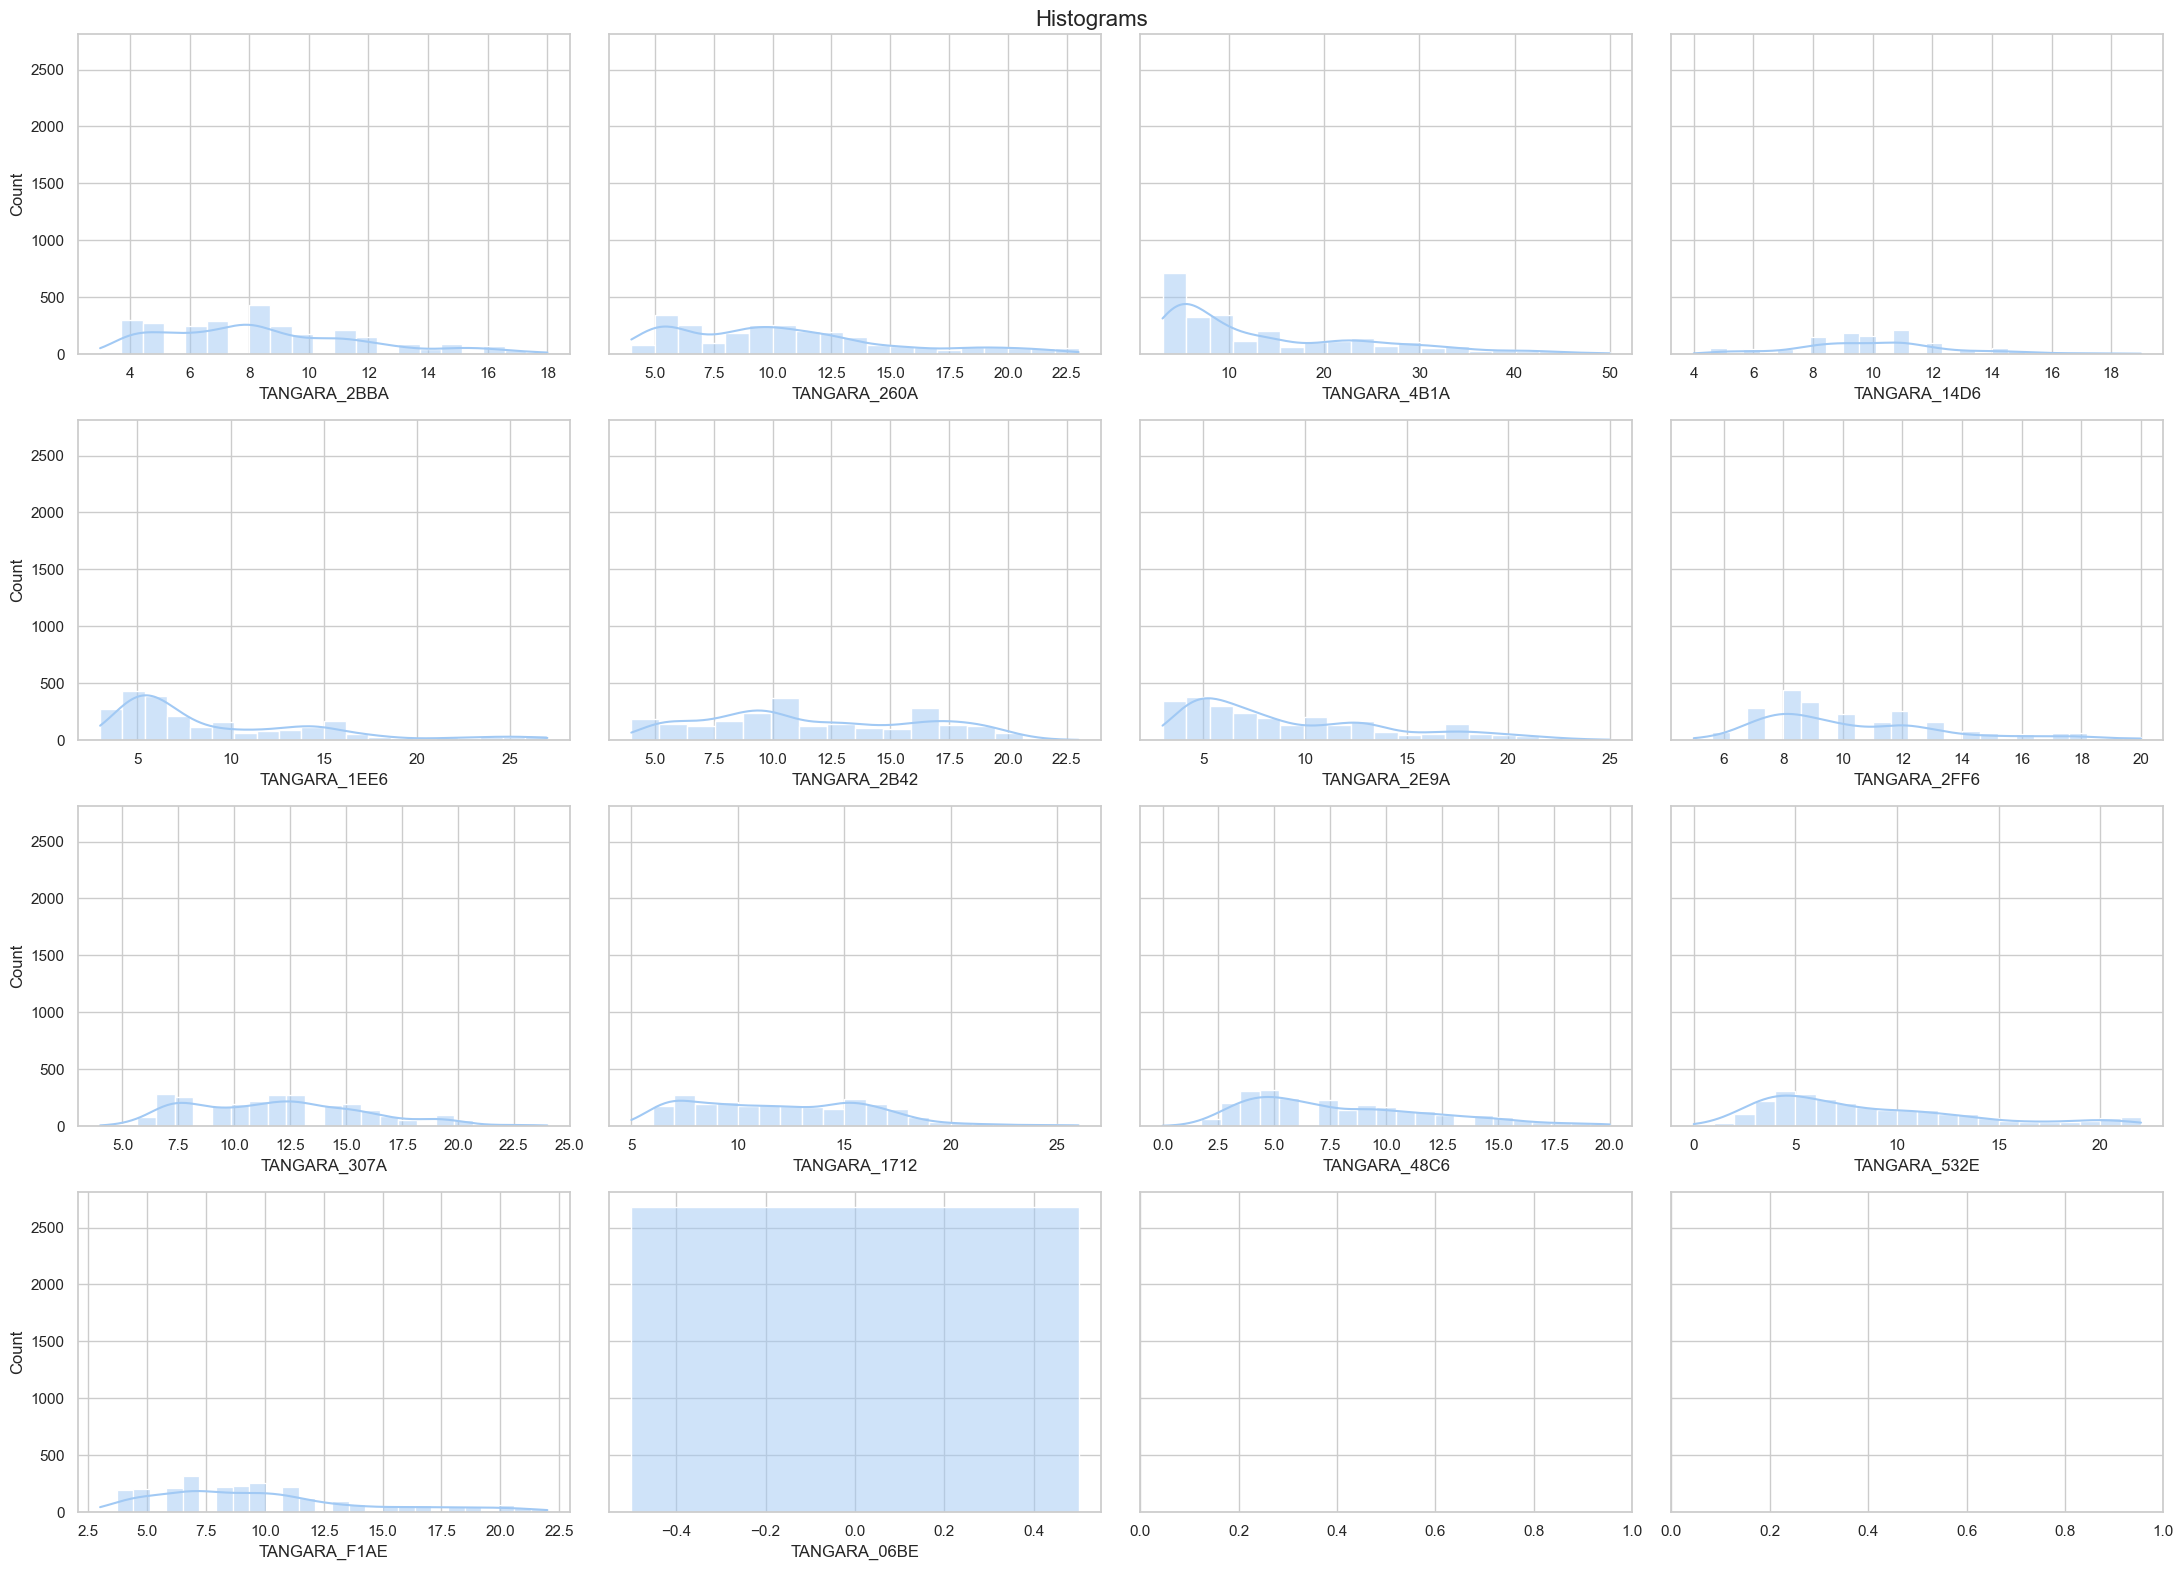

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

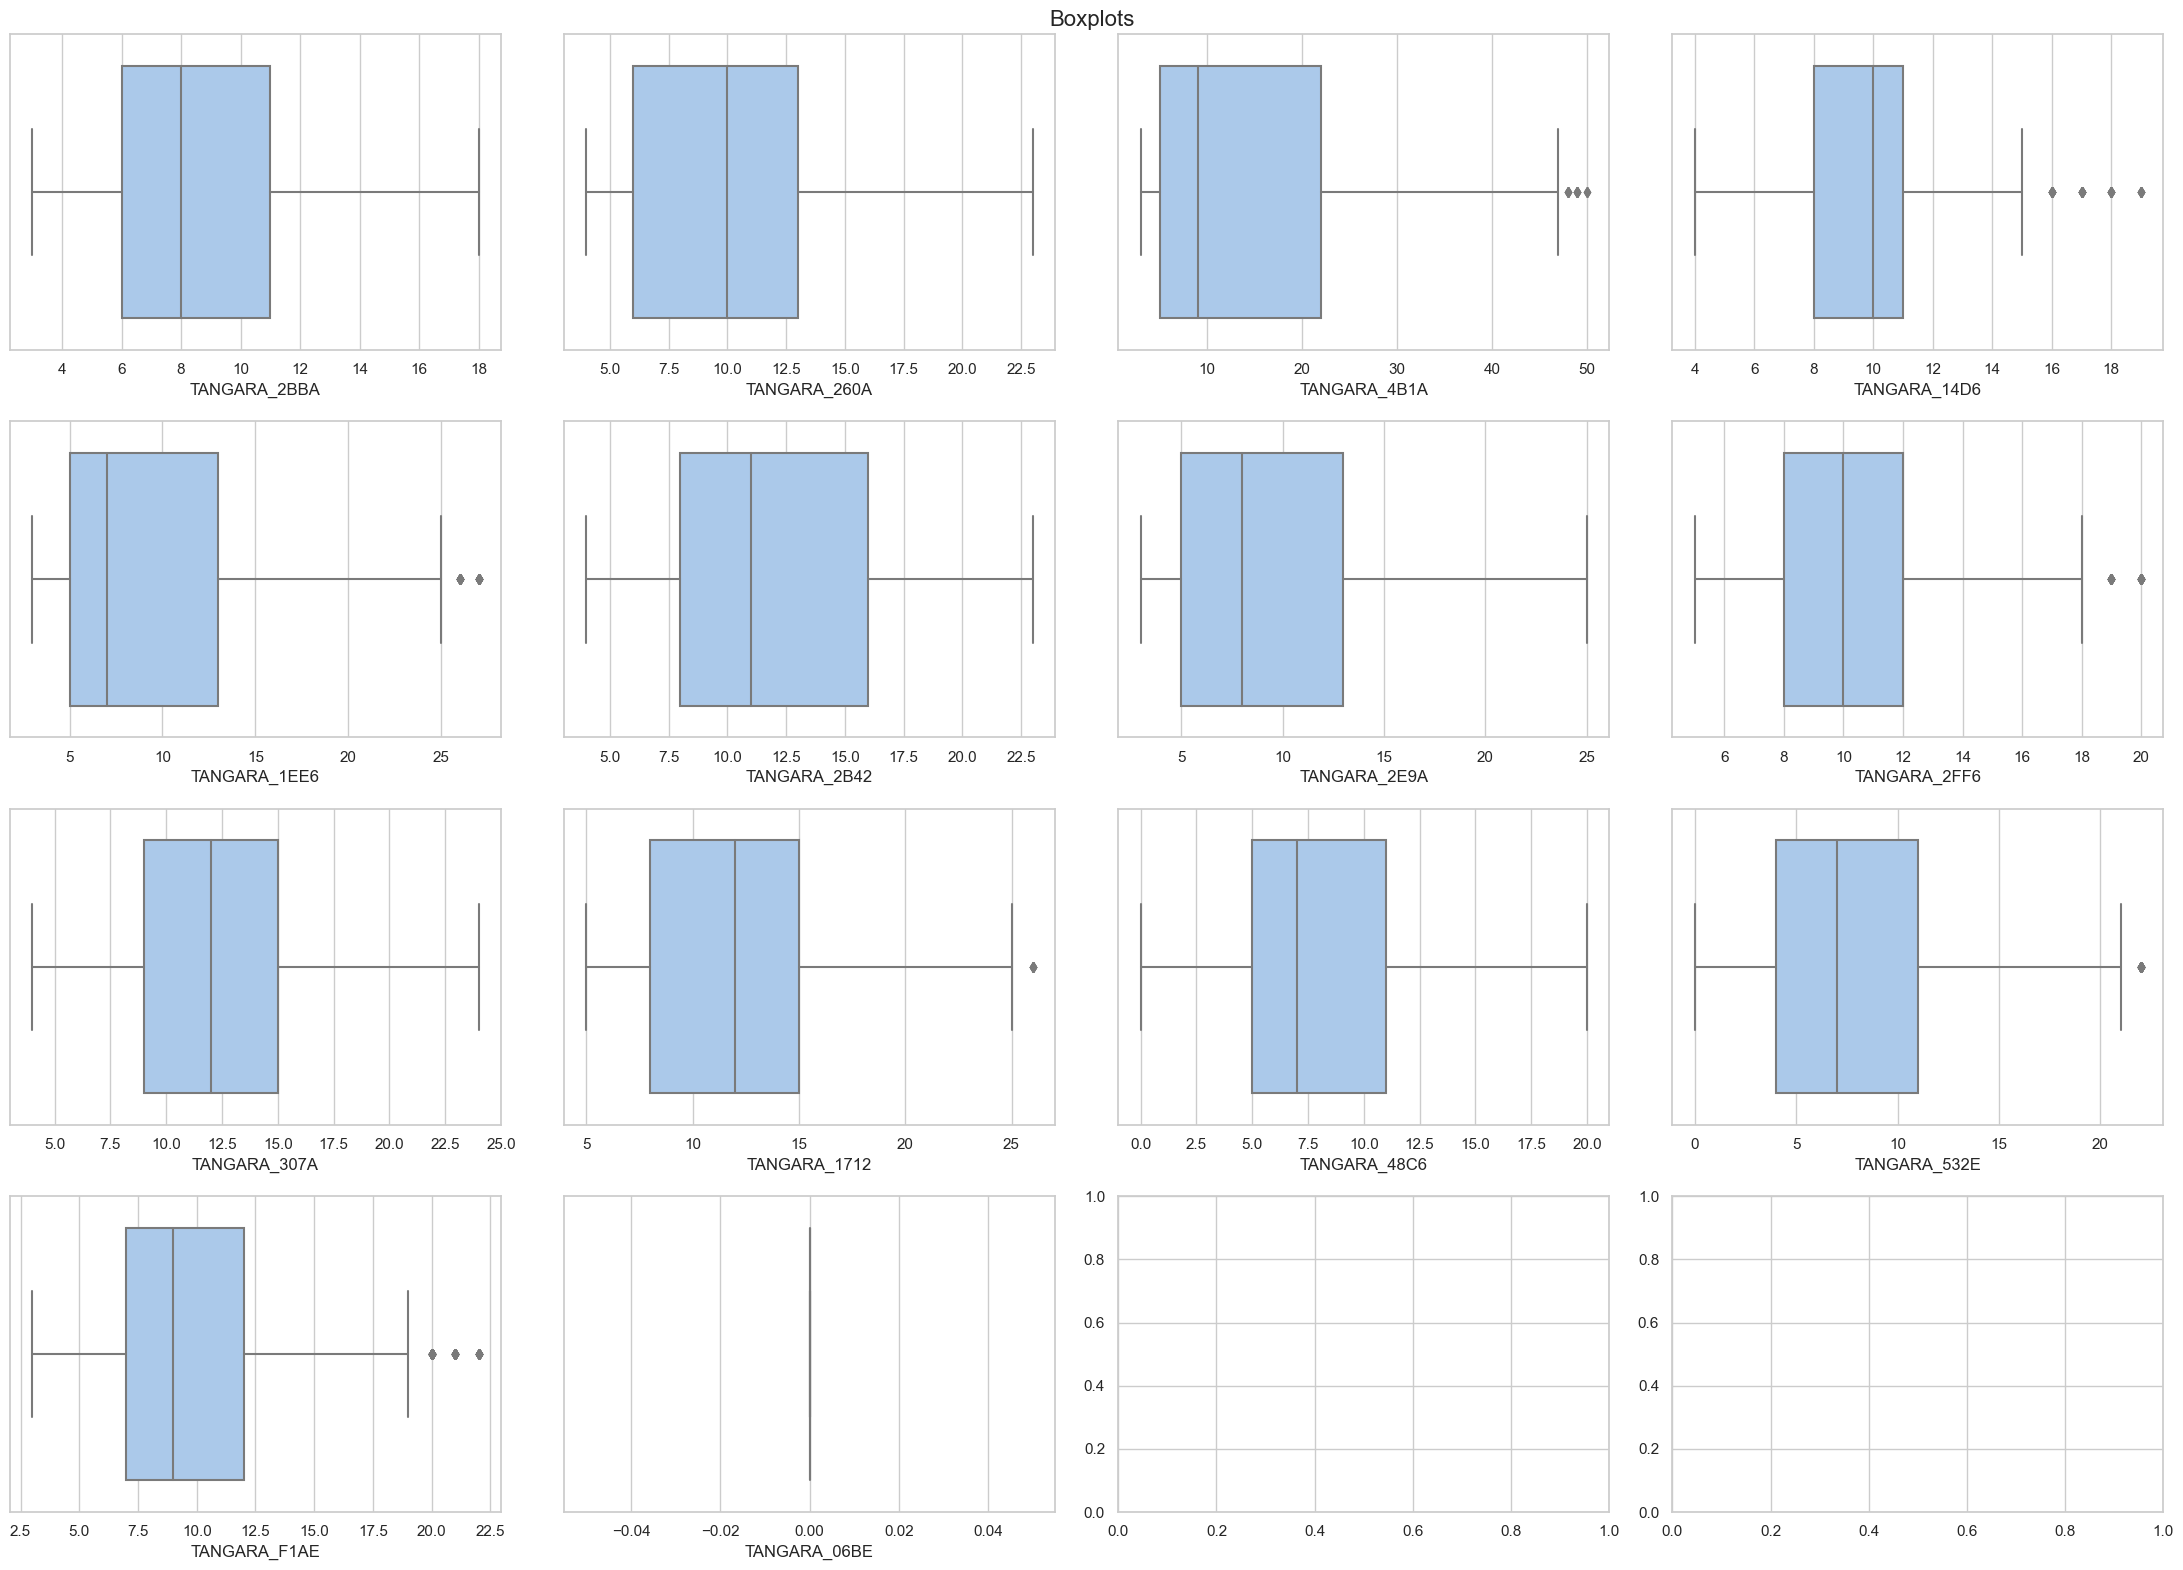

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

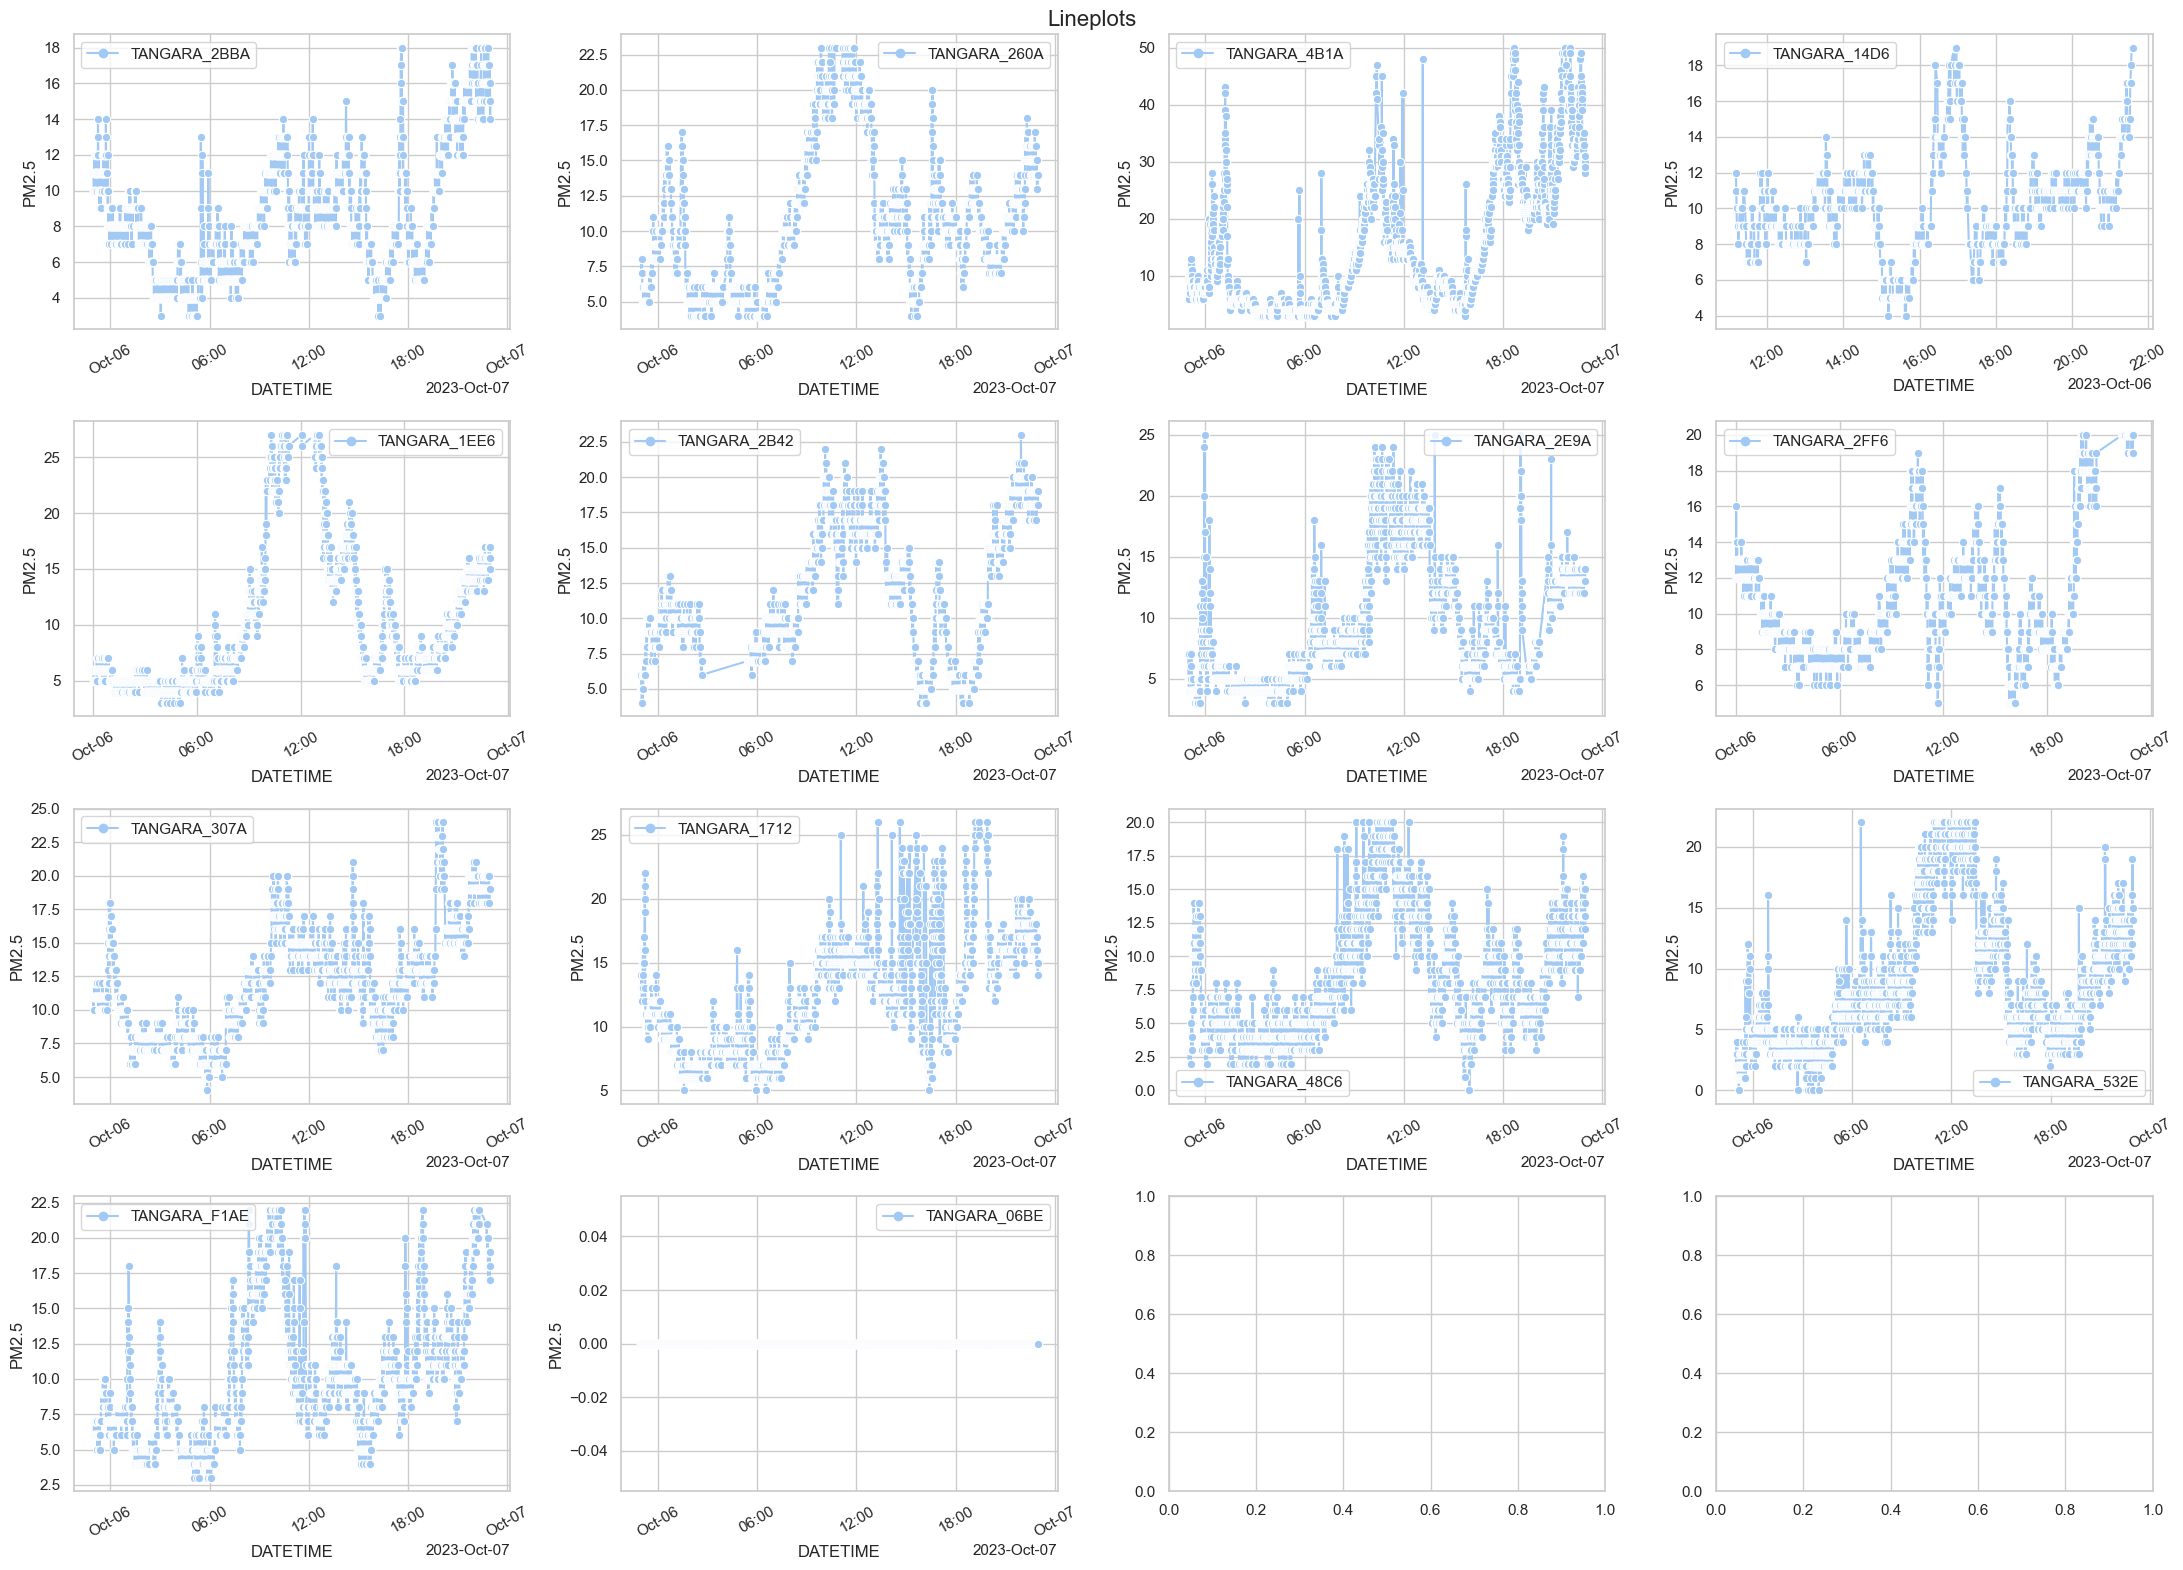

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')